In [1]:
# Librerias
import os
from unidecode import unidecode
import datetime
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Parámetros
inputFolder = "1-input"
processFolder = "2-process"
outputFolder = "3-output"
otherOutputFolder = "../4-modelling/1-input/"
otherOutputFolder2 = "../5-evaluation/1-input/main/"
logsFolder = "4-logs"

inputMainFolder = inputFolder + r"\main"
inputMastersFolder = inputFolder + r"\masters"

processMainFolder = processFolder + r"\main"
processSupportFolder = processFolder + r"\support"

dataVisualizationTopLimit = 20

In [3]:
# Funciones utilitarias
def find_nth(haystack, needle, n):
    start = haystack.find(needle)
    while start >= 0 and n > 1:
        start = haystack.find(needle, start+len(needle))
        n -= 1
    return start

def find_nth_right(haystack, needle, n):
    start = haystack.rfind(needle)
    while start >= 0 and n > 1:
        start = haystack.rfind(needle, 0, start-len(needle))
        n -= 1
    return start

def parseLineBreaksAndAccents(text):
  return unidecode(" ".join(text.split()))

def parseNames(text):
  return text.strip().title()

def findTags(tag, color):
  return tag.find("span", {"style": 'font-size:10.0pt;font-family:"Arial",sans-serif;mso-fareast-font-family:\n"Times New Roman";color:' + color })

def getChildIndex(mainChildTags, title, color):
  return next((index for index, tag in enumerate(mainChildTags) if ( parseNames(parseLineBreaksAndAccents(findTags(tag, color).text)) == title if findTags(tag, color) else False )), None)

def getSectionsIndexes(mainChildTags, color):
  sectionsIndexes = []
  sectionsTitle = ["Objetivo Laboral", "Experiencia Laboral", "Educacion", "Informatica", "Idiomas", "Otros Conocimientos"]
  
  for sectionTitle in sectionsTitle:
    sectionIndex = getChildIndex(mainChildTags, sectionTitle, color)
    sectionsIndexes.append(sectionIndex)
  
  sectionsIndexes.append(len(mainChildTags)-1)
  return sectionsIndexes

def getNextSectionIndexValid(sectionsIndexes, i):
  while(not sectionsIndexes[i]):
    i = i + 1

  return sectionsIndexes[i]

def getStartAndEndIndex(sectionsIndexes, i):
  return sectionsIndexes[i], getNextSectionIndexValid(sectionsIndexes, i+1)

def getCompare(data, fields):
  return (list(set([" ".join(x for x in [elem[y] for y in fields] if x) for elem in data if elem])))

def showNullValues(df):
  percentNulls = df.isnull().sum() / len(df)
  resultDf = pd.DataFrame({'columnName': df.columns, 'columnType': df.dtypes.to_dict().values(), 'percentNulls': percentNulls })
  resultDf = resultDf.sort_values('percentNulls', ascending=False).reset_index(drop=True)
  #Ajustes para la visualización
  resultDf.index = range(1,len(resultDf)+1)
  resultDf.loc[resultDf["columnType"] == "object", "columnType"] = "Categórico"
  resultDf.loc[resultDf["columnType"] == "float64", "columnType"] = "Numérico"
  resultDf.loc[resultDf["columnType"] == "int64", "columnType"] = "Numérico"

  resultDf["percentNulls"] =  (resultDf["percentNulls"]*100).map('{:,.2f}%'.format)

  display(resultDf)

def showAtypicalValues(df):
  originalDf = df.copy()
  columns = [columnName for columnName, columnType in df.dtypes.to_dict().items()]
  numericalColumns = [columnName for columnName, columnType in df.dtypes.to_dict().items() if columnName not in [ "contratado" ] and columnType == "float64" ]

  for column in columns:
    if column in numericalColumns:
      firstQuartil, thirdQuartil = np.percentile(df[column], 25), np.percentile(df[column], 75)
      interQuartilRange = thirdQuartil - firstQuartil
      bottomLimit, topLimit = firstQuartil - 3*interQuartilRange, thirdQuartil + 3*interQuartilRange

      # Reemplazando los valores
      df[column] = df[column].map(lambda x: True if (x < bottomLimit or x > topLimit) else False)
    else:
      df[column] = df[column].map(lambda x: False)
  
  percentAtypical = df.sum() / len(df)

  resultDf = pd.DataFrame({'columnName': df.columns, 'columnType': originalDf.dtypes.to_dict().values(), 'percentAtypical': percentAtypical })
  resultDf = resultDf.sort_values('percentAtypical', ascending=False).reset_index(drop=True)
  #Ajustes para la visualización
  resultDf.index = range(1,len(resultDf)+1)
  resultDf.loc[resultDf["columnType"] == "object", "columnType"] = "Categórico"
  resultDf.loc[resultDf["columnType"] == "float64", "columnType"] = "Numérico"
  resultDf.loc[resultDf["columnType"] == "int64", "columnType"] = "Numérico"

  resultDf["percentAtypical"] =  (resultDf["percentAtypical"]*100).map('{:,.2f}%'.format)

  display(resultDf)

In [4]:
# Funciones utilitarias de archivos
def readCsvAsDict(filePath, delimiter=",", encoding="utf-8", header=0, dtype={}):
  df = pd.read_csv(filePath, delimiter=delimiter,encoding=encoding, header=header, dtype=dtype)
  df = df.replace(np.nan, '', regex=True)
  data = df.to_dict('records')
  return data

def readCsvAsDf(filePath, delimiter=",", encoding="utf-8", header=0, dtype={}):
  df = pd.read_csv(filePath, delimiter=delimiter,encoding=encoding, header=header, dtype=dtype)
  df = df.replace(np.nan, '', regex=True)
  return df

def writeDictToCsv(data, pathCsv, encoding='utf-8'):
  with open(pathCsv, 'w', newline='', encoding=encoding) as f:
    if data:
      writer = csv.DictWriter(f, fieldnames=data[0].keys(), lineterminator='\n')
      writer.writeheader()
      writer.writerows(data)
    else:
      f.write("")

def writeDfToCsv(data, pathCsv, encoding='utf-8', header=True):
  data.to_csv(path_or_buf = pathCsv, encoding = encoding, index=False, header=header)

In [5]:
def readAndWritePreprocessedData(df, masters):
  ## Decisiones propias para el modelo

  # Acotando registros por fecha de inicio
  df['fechaPostulacion']= pd.to_datetime(df['fechaPostulacion'])
  df = df[df["fechaPostulacion"] > datetime.datetime(2019,6,21,0,0,0)]

  # Eliminando columnas que son datos sensibles de los candidatos
  sensitiveColumns = [
    "nombreCompleto", "numeroDocumento", "fechaNacimiento", "direccion", "numeroCasa", "numeroCelular", "correoElectronico"
  ]
  df = df.drop(columns=sensitiveColumns)

  # Eliminando columnas que no se usarán, porque no son relevantes para el modelo
  nonRelevanceColumns = [
    "fechaPostulacion", "idConvocatoria", "objetivoLaboral", "descripcionUltimoTrabajo"
  ]
  df = df.drop(columns=nonRelevanceColumns)

  # Eliminando columnas normadas por Ley N° 26772: Igualdad de oportunidades y de trato
  lawRestrictiveColumns = [
    "estadoCivil", "paisNacimiento"
  ]
  df = df.drop(columns=lawRestrictiveColumns)

  # Aplicar las equivalencias a los campos: nombrePerfilConvocatoria, empresaUltimoTrabajo, nombreUltimoTrabajo, institucionUltimoEstudio, nombreUltimoEstudio
  equivalences = ["nombrePerfilConvocatoria", "empresaUltimoTrabajo", "nombreUltimoTrabajo", "institucionUltimoEstudio", "nombreUltimoEstudio"]

  # Mejorar las equivalencias poco a poco
  for index, equivalence in enumerate(equivalences):
    df = pd.merge(df, masters[index], on=equivalence)
    df[equivalence] = df["equivalencia"]
    df = df.drop(columns=["equivalencia", "cantidad", "igual"])

  ## Decisiones por la metodología

  # Analisis de valores nulos
  # Reemplazando las cadenas vacias a NaN
  categoricalColumns = [columnName for columnName, columnType in df.dtypes.to_dict().items() if columnName not in [ "contratado" ] and columnType == "object" ]
  for column in categoricalColumns:
    df[column] = df[column].replace('',None,regex = True).astype("object")

  # Reemplazando los ceros a NaN
  numericalColumns = [columnName for columnName, columnType in df.dtypes.to_dict().items() if columnName not in [ "contratado" ] and columnType == "float64" ]
  for column in numericalColumns:
    df[column] = df[column].replace(0,None).astype('float64')

  # Obteniendo el porcentaje de nulos por columna
  showNullValues(df)
  
  # Tecnica 1: Eliminar la columna si sobrepasa el 30% de nulos
  # Al ninguno superar el 30% de nulos, no se eliminará ninguna columna

  # Tecnica 2: Reemplazar NaN por aleatorizacion de valores no nulos, para variables categoricas
  np.random.seed(0)

  for column in categoricalColumns:
    df[column] = df[column].map(lambda x: x if not pd.isna(x) else np.random.choice(df[column].dropna().tolist()))

  showNullValues(df)

  # Tecnica 3: Reemplazar NaN por el promedio de valores no nulos, para variables numericas
  for column in numericalColumns:
    df[column] = df[column].map(lambda x: x if not pd.isna(x) else round(float(df[column].dropna().mean()), 1) )

  # Obteniendo el nuevo porcentaje de nulos por columna
  showNullValues(df)

  # Reemplazo de valores atipicos (outliers) (variables numericas)
  atypicalDf = df.copy()
  showAtypicalValues(atypicalDf)

  # Analizando valores atipicos extremos
  for column in numericalColumns:
    firstQuartil, thirdQuartil = np.percentile(df[column], 25), np.percentile(df[column], 75)
    interQuartilRange = thirdQuartil - firstQuartil
    bottomLimit, topLimit = firstQuartil - 3*interQuartilRange, thirdQuartil + 3*interQuartilRange

    # Reemplazando los valores
    df[column] = df[column].map(lambda x: bottomLimit if x < bottomLimit else x)
    df[column] = df[column].map(lambda x: topLimit if x > topLimit else x)

  atypicalDf = df.copy()
  showAtypicalValues(atypicalDf)

  writeDfToCsv(df, os.path.join(outputFolder, 'result.csv'))
  writeDfToCsv(df, os.path.join(otherOutputFolder, 'result.csv'))
  writeDfToCsv(df, os.path.join(otherOutputFolder2, 'result.csv'))

  return df

In [6]:
def visualizeData(mergedMainData):
  df = pd.DataFrame(mergedMainData)

  print(df.dtypes)
  print(df.count())

  columns = [columnName for columnName in df.columns]

  for column in columns:
    topDf = df[column].value_counts().head(dataVisualizationTopLimit)
    print(topDf)
    y_axis = list(reversed(topDf.index))
    x_axis = list(reversed(topDf.values))
    plt.ylabel(column)
    plt.barh(y_axis, x_axis)
    plt.show()

In [7]:
def main():
  # Definiendo el inicio del proceso
  startTime = datetime.datetime.now()
  print("Inicio: " + str(startTime))

  isPreprocessed = True

  # Leyendo la data obtenida en el entendimiento de los datos
  bumeranData = readCsvAsDf(os.path.join(inputMainFolder, 'result.csv')) # Ver si se puede cambiar a csv
  
  # Leyendo archivos maestros
  jobProfileName = readCsvAsDf(os.path.join(inputMastersFolder, 'nombrePerfilConvocatoria.csv'))
  lastWorkCompany = readCsvAsDf(os.path.join(inputMastersFolder, 'empresaUltimoTrabajo.csv'))
  lastWorkName = readCsvAsDf(os.path.join(inputMastersFolder, 'nombreUltimoTrabajo.csv'))
  lastEducationInstitution = readCsvAsDf(os.path.join(inputMastersFolder, 'institucionUltimoEstudio.csv'))
  lastEducationName = readCsvAsDf(os.path.join(inputMastersFolder, 'nombreUltimoEstudio.csv'))

  # Aplicando los datos de los maestros y validaciones
  preprocessedData = readCsvAsDict(os.path.join(outputFolder, 'result.csv')) if isPreprocessed else readAndWritePreprocessedData(bumeranData, [jobProfileName, lastWorkCompany, lastWorkName, lastEducationInstitution, lastEducationName])
  print("Se terminó el preprocesamiento")

  visualizeData(preprocessedData)

  # Definiendo el fin del proceso
  endTime = datetime.datetime.now()
  print("Fin: " + str(endTime))
  print("Tiempo: " + str(endTime-startTime))

Inicio: 2023-07-30 23:03:12.779161
Se terminó el preprocesamiento
nombrePerfilConvocatoria     object
paisResidencia               object
sueldoPretendido            float64
diasUltimoTrabajo           float64
empresaUltimoTrabajo         object
paisUltimoTrabajo            object
areaUltimoTrabajo            object
nombreUltimoTrabajo          object
aniosExperiencia            float64
numeroTrabajos              float64
diasUltimoEstudio           float64
institucionUltimoEstudio     object
paisUltimoEstudio            object
areaUltimoEstudio            object
nombreUltimoEstudio          object
estadoUltimoEstudio          object
gradoUltimoEstudio           object
aniosEstudio                float64
numeroEstudios              float64
habilidadesTecnicas         float64
idiomas                     float64
otrasHabilidades            float64
contratado                    int64
dtype: object
nombrePerfilConvocatoria    10562
paisResidencia              10562
sueldoPretendido        

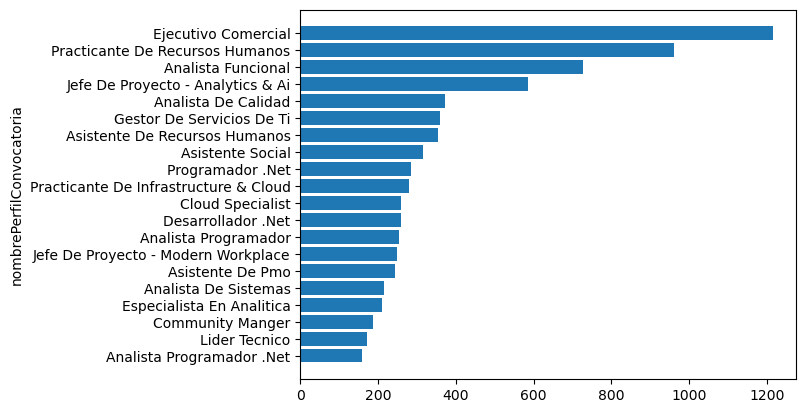

Peru                    10376
Venezuela                 148
Argentina                  11
Colombia                    9
Brasil                      4
Ecuador                     3
Republica Dominicana        3
Chile                       2
El Salvador                 1
Panama                      1
Espana                      1
Costa Rica                  1
Francia                     1
Bolivia                     1
Name: paisResidencia, dtype: int64


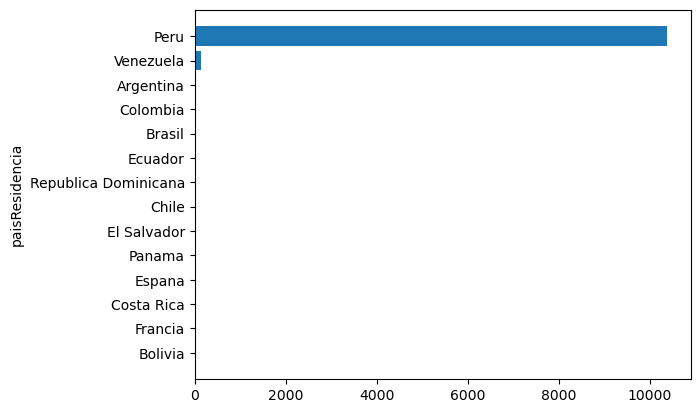

5000.0    641
2500.0    639
2000.0    601
3500.0    593
3000.0    574
4000.0    560
1500.0    484
6000.0    463
4500.0    434
4301.8    404
1200.0    364
1800.0    360
5500.0    326
6500.0    305
1025.0    298
7000.0    296
1000.0    282
930.0     227
1.0       210
8000.0    208
Name: sueldoPretendido, dtype: int64


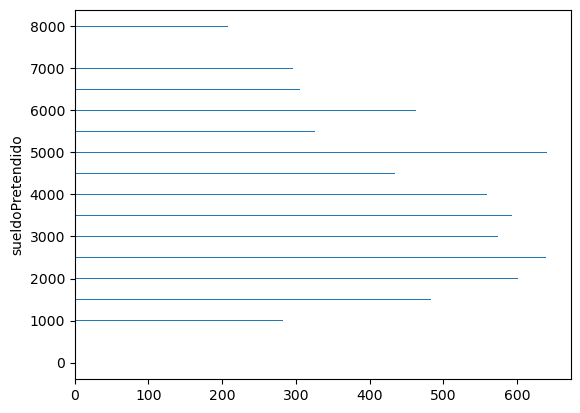

657.5     604
2619.0    241
153.0     166
61.0      165
92.0      155
122.0     152
365.0     140
184.0     105
212.0      98
31.0       88
91.0       87
214.0      87
151.0      83
181.0      83
334.0      82
273.0      76
183.0      69
59.0       66
275.0      65
366.0      63
Name: diasUltimoTrabajo, dtype: int64


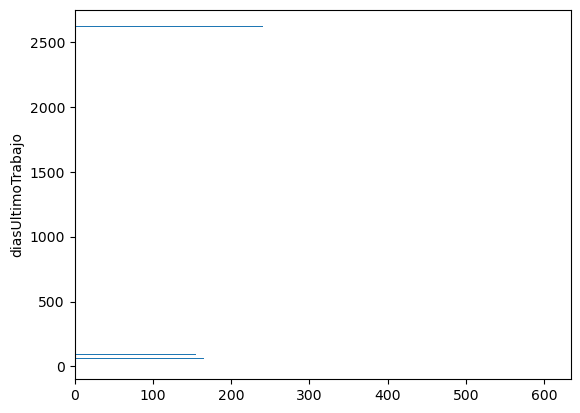

Freelance                                          224
Ntt Data Peru S.A.C.                               186
Canvia S.A.C.                                      174
Global Hitss Peru S.A.C.                           127
Mdp Consulting S.A.C.                              123
Manpower Professional Services S.A.                111
Indra Peru S.A.                                     96
Telefonica Del Peru                                 91
Banco De Credito Del Peru - Bcp                     88
Stefanini It Solutions                              78
Corporacion Sapia S.A.                              60
Tata Consultancy Services                           60
Universidad Peruana De Ciencias Aplicadas (Upc)     50
Ferreyros S.A.                                      45
Tgestiona Sac                                       44
America Movil Peru S.A.C.                           43
Oficina Nacional De Procesos Electorales (Onpe)     41
Gfi Peru Sac                                        41
Pontificia

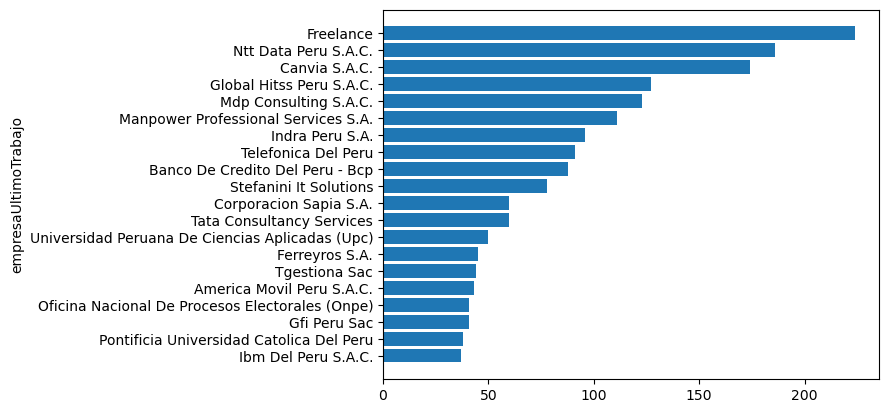

Peru              10376
Estados Unidos       32
Venezuela            26
Espana               25
Brasil               17
Colombia             17
Chile                16
Argentina             7
Ecuador               7
Mexico                4
Albania               3
Reino Unido           3
Italia                3
Costa Rica            3
Francia               3
Australia             2
Paises Bajos          2
Finlandia             2
Panama                2
Alemania              1
Name: paisUltimoTrabajo, dtype: int64


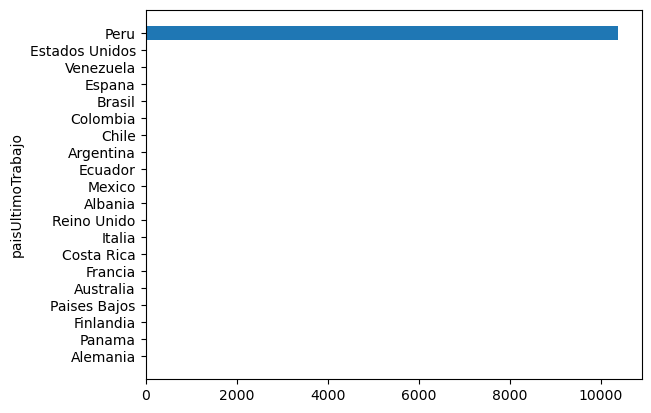

Tecnologia / Sistemas            1149
Tecnologias De La Informacion    1119
Liderazgo De Proyecto             649
Programacion                      615
Comercial                         589
Sistemas                          524
Recursos Humanos                  484
Analisis Funcional                307
Administracion                    284
Ventas                            283
Analisis De Datos                 254
Infraestructura                   227
Soporte Tecnico                   221
Atencion Al Cliente               182
Seguridad Informatica             173
Otras Ingenierias                 161
Testing / Qa / Qc                 145
Desarrollo De Negocios            139
Telecomunicaciones                134
Administracion De Personal        120
Name: areaUltimoTrabajo, dtype: int64


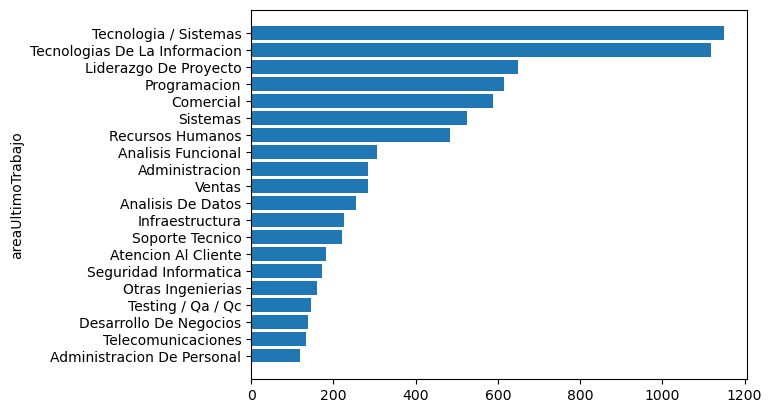

Analista Programador                            584
Analista De Sistemas                            286
Analista Funcional                              262
Jefe De Proyectos                               193
Analista De Calidad                             128
Asistente Administrativo                        127
Trabajadora Social                              113
Ejecutivo Comercial                             102
Asistente De Recursos Humanos                    97
Project Manager                                  93
Supervisor De Infraestructura De Redes Cisco     90
Docente                                          80
Practicante Profesional                          80
Practicante Pre Profesional                      74
Asesor Comercial                                 74
Soporte Tecnico                                  70
Lider Tecnico                                    68
Practicante De Recursos Humanos                  64
Analista De Procesos                             61
Gerente De P

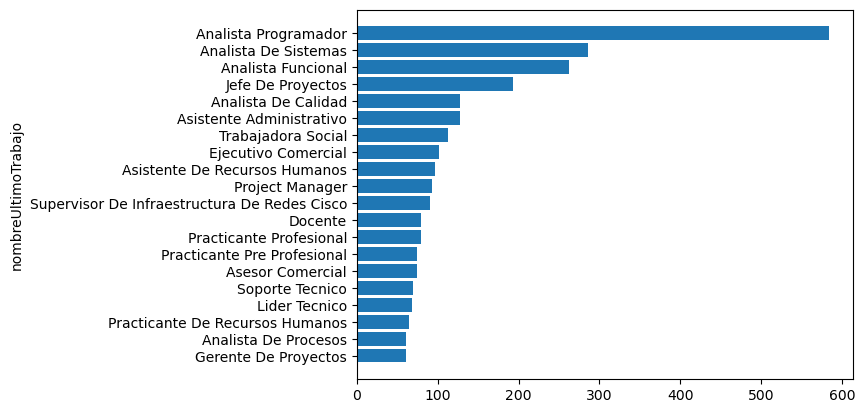

8.7     645
4.3     106
4.8     106
8.8      96
5.8      94
0.2      93
2.8      91
1.9      90
6.8      88
32.9     85
5.9      85
8.4      83
7.7      82
7.3      82
1.2      81
0.5      79
1.0      79
6.3      79
8.3      79
7.0      78
Name: aniosExperiencia, dtype: int64


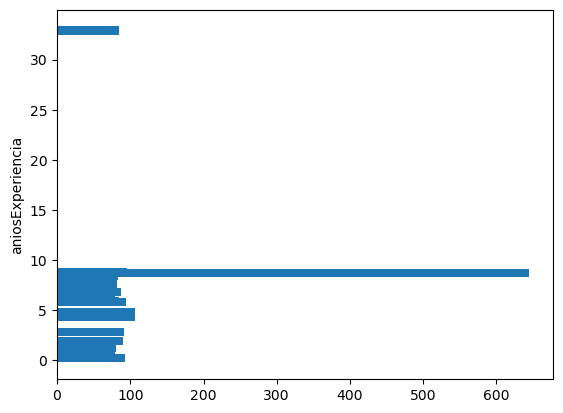

5.0     1328
4.0     1229
6.0     1108
3.0     1047
7.0      979
8.0      754
2.0      747
1.0      671
6.1      568
9.0      556
10.0     419
11.0     288
12.0     250
13.0     157
14.0     127
15.0      99
17.0      63
20.0      52
16.0      48
19.0      40
Name: numeroTrabajos, dtype: int64


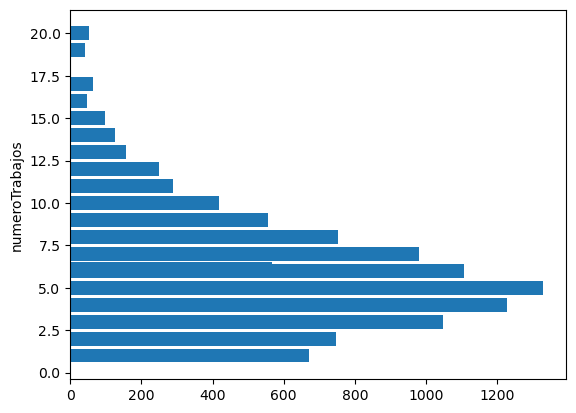

1226.9    726
31.0      322
61.0      250
30.0      218
1736.0    204
92.0      161
1705.0    148
122.0     146
1948.0    131
153.0     124
2101.0    106
1795.0    105
91.0       87
1826.0     82
183.0      67
2161.0     65
1157.0     63
1096.0     63
1218.0     61
2070.0     61
Name: diasUltimoEstudio, dtype: int64


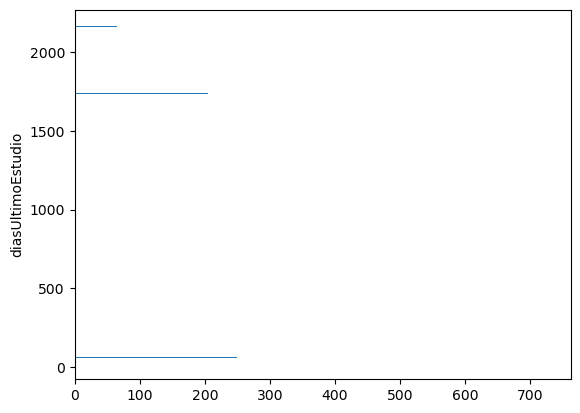

Universidad Peruana De Ciencias Aplicadas    931
Universidad Tecnologica Del Peru             550
Instituto Cibertec                           446
Pontificia Universidad Catolica Del Peru     365
Universidad Privada Del Norte                358
Universidad San Ignacio Del Loyola           343
Universidad Nacional Mayor De San Marcos     337
Universidad Cesar Vallejo                    310
Universidad Esan                             298
Universidad De Lima                          252
Universidad Nacional De Ingenieria           226
Universidad De San Martin De Porres          224
Universidad Nacional Federico Villarreal     201
Universidad Ricardo Palma                    201
Instituto San Ignacio De Loyola              184
Universidad Inca Garcilaso De La Vega        183
Tecsup                                       131
Instituto Superior Tecnologico Idat          124
Universidad Del Pacifico                     116
Universidad Nacional Del Callao              104
Name: institucionUlt

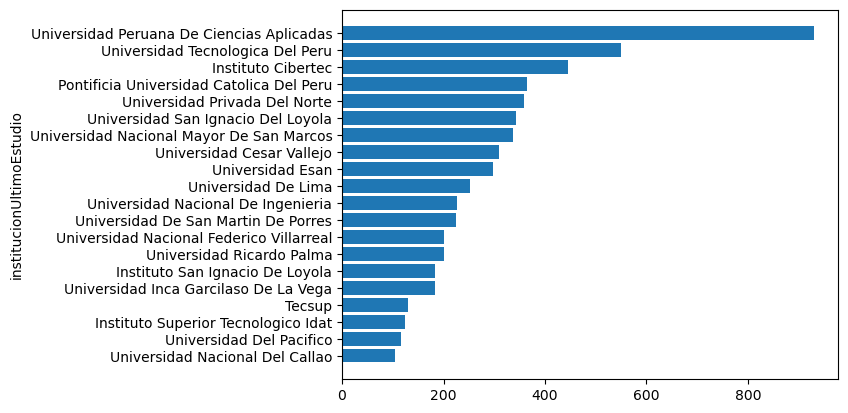

Peru              9933
Espana             207
Venezuela          165
Estados Unidos      78
Mexico              34
Argentina           21
Colombia            20
Brasil              19
Chile               18
Costa Rica          14
Canada               8
Ecuador              6
Bolivia              6
Australia            5
Francia              5
Alemania             3
Reino Unido          3
India                3
Internacional        2
Cuba                 2
Name: paisUltimoEstudio, dtype: int64


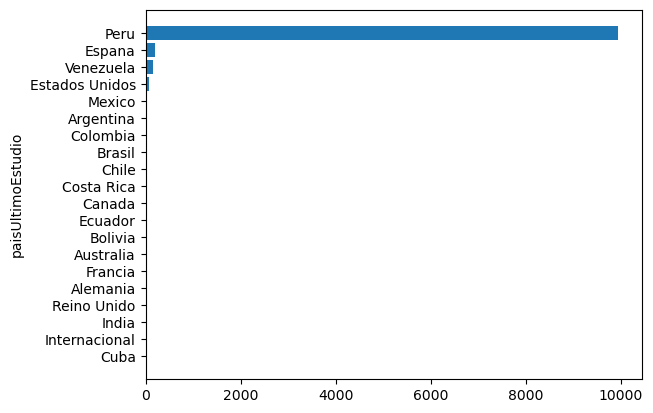

Ing. En Sistemas                  2457
Tecnologias De La Informacion     1305
Adm. De Empresas                  1180
Ing. Informatica                   649
Ing. Industrial                    521
Computacion / Informatica          508
Marketing / Comercializacion       379
Recursos Humanos / Relac. Ind.     364
Otra                               363
Psicologia                         356
Ing. - Otros                       201
Trabajo Social                     163
Analisis De Sistemas               149
Ing. Telecomunicaciones            131
Programacion                       122
Telecomunicaciones                 120
Procesos / Calidad Total           118
Finanzas                           102
Bachiller                          100
Ing. Electronica                    98
Name: areaUltimoEstudio, dtype: int64


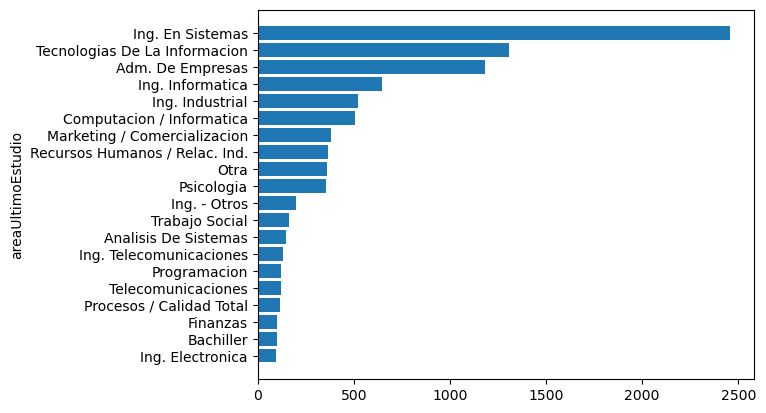

Ingenieria De Sistemas                       1706
Ingenieria Industrial                         397
Psicologia                                    316
Administracion De Empresas                    232
Computacion E Informatica                     184
Ingenieria Informatica                        167
Bachiller En Ingenieria De Sistemas           155
Master In Business Administration (Mba)       151
Administracion                                131
Marketing                                     127
Administracion Y Negocios Internacionales      96
Ingenieria Empresarial                         91
Ingenieria De Software                         89
Ingenieria De Computacion Y Sistemas           88
Ingles                                         87
Scrum Master                                   86
Trabajo Social                                 84
Ingenieria De Redes Y Comunicaciones           82
Ingenieria Electronica                         81
Gestion De Proyectos                           78


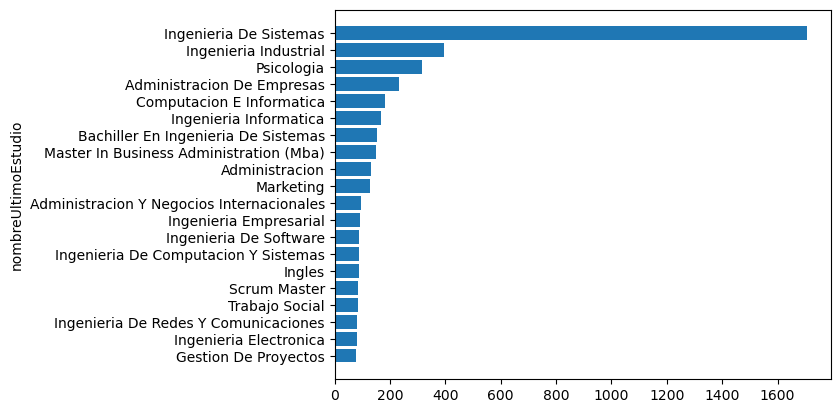

Graduado      6951
En Curso      3432
Abandonado     179
Name: estadoUltimoEstudio, dtype: int64


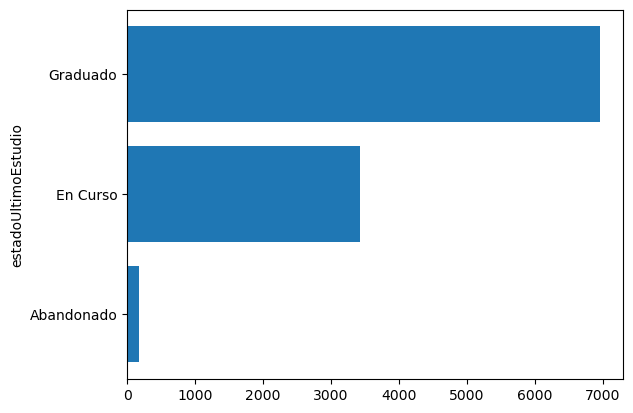

Universitario        5207
Otro                 2379
Posgrado             1271
Terciario/Tecnico    1042
Master                639
Doctorado              13
Secundario             11
Name: gradoUltimoEstudio, dtype: int64


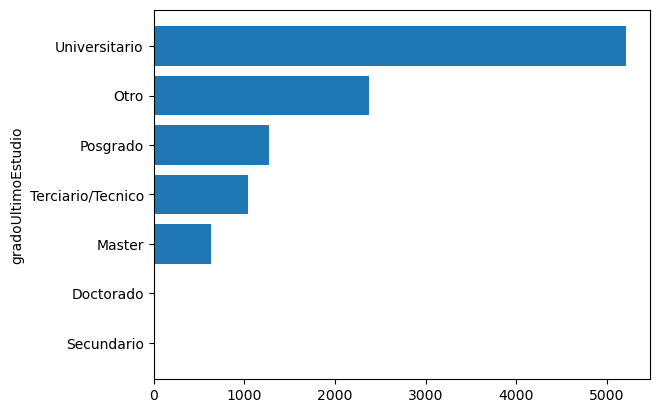

5.3     328
4.8     327
6.3     278
5.8     255
7.7     253
4.7     245
5.0     206
6.8     203
4.9     199
7.8     181
5.7     178
5.9     178
21.0    173
5.4     163
7.3     162
7.4     153
6.5     149
4.5     139
8.3     133
6.9     129
Name: aniosEstudio, dtype: int64


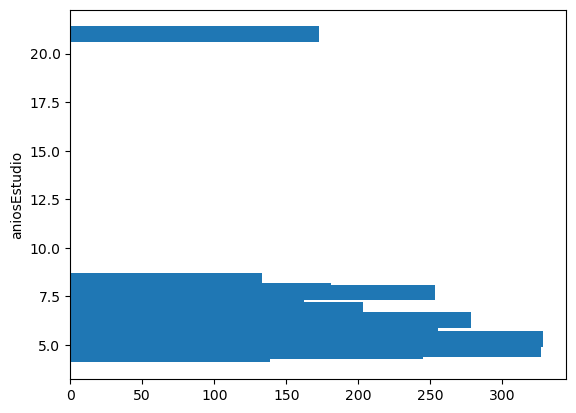

1.0     3911
2.0     2426
3.0     1213
4.0      730
5.0      491
6.0      438
7.0      304
13.0     283
8.0      197
9.0      152
3.2      128
11.0     121
10.0      96
12.0      72
Name: numeroEstudios, dtype: int64


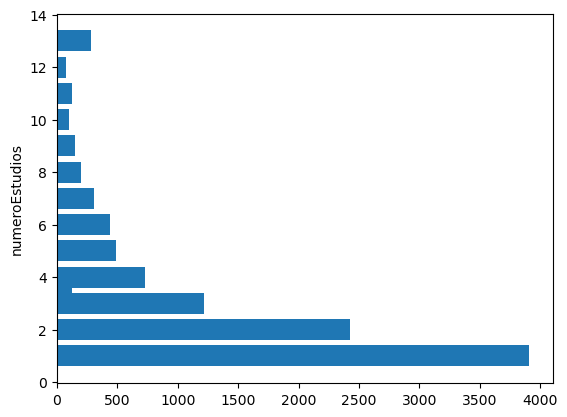

9.3     1250
1.0     1153
3.0      880
2.0      827
4.0      704
5.0      612
6.0      542
7.0      509
9.0      465
8.0      445
11.0     353
10.0     351
35.0     297
12.0     270
13.0     251
16.0     246
14.0     193
15.0     162
17.0     129
18.0     126
Name: habilidadesTecnicas, dtype: int64


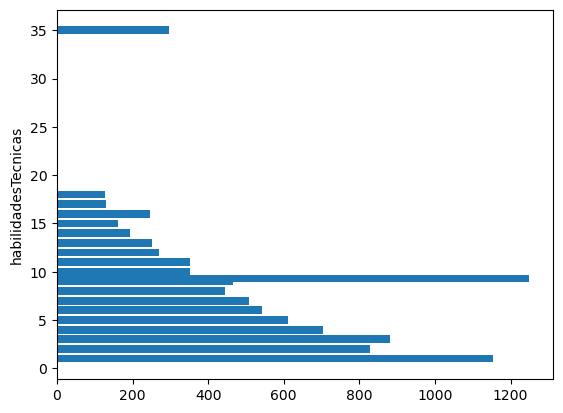

1.0    7352
2.0    2048
1.3     787
2.2     375
Name: idiomas, dtype: int64


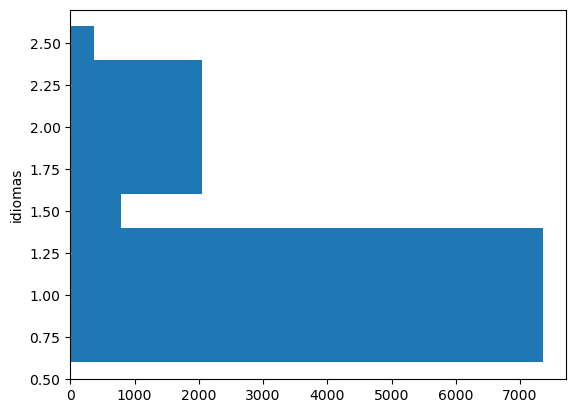

5.4     2413
1.0     1780
2.0     1204
3.0      871
4.0      775
5.0      663
6.0      521
7.0      449
8.0      360
18.0     286
9.0      278
10.0     228
11.0     183
12.0     152
13.0     123
14.0      98
15.0      73
17.0      55
16.0      50
Name: otrasHabilidades, dtype: int64


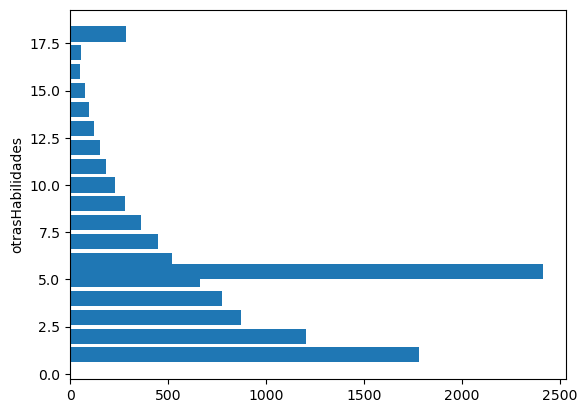

0    10058
1      504
Name: contratado, dtype: int64


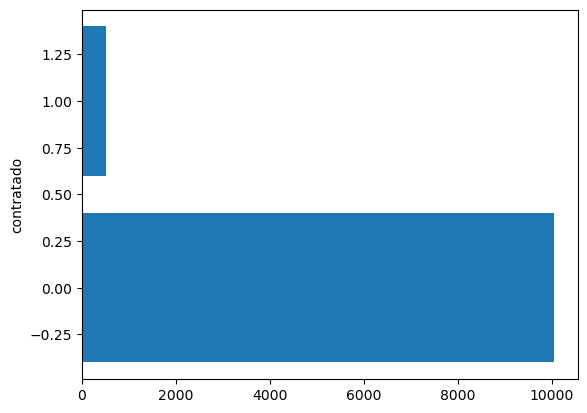

Fin: 2023-07-30 23:03:15.819507
Tiempo: 0:00:03.040346


In [8]:
if __name__ == "__main__":
  main()